# Assignment 3 - Monte Carlo Methods

In this notebook we will:

- Implement Episode Generation
- Implement MC Policy Evaluation 
- Implement MC On-Policy Control 
- Analysis of MC on Fishlake 

## Blackjack - A Model-free Environment, Monte Carlo Methods

Let us now try Monte Carlo methods on a model-free environment (where it is very hard / impossible to use Dynamic Programming). We will use the game of Black Jack, as presented in the lecture. In general, MC methods are model free, but you might have used some convenience functions

<div class="alert alert-info">

The following description is adapted from the environment description at https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py:

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over. They're playing against dealer
    that follows a fixed strategy.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    
    This game is played with an infinite deck (drawing with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.
    
    If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    
    The reward for winning is +1, drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of:
    
    the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.

### Preliminaries

What follows are the imports, the instantiation of the BlackJack gym-environment, and the introduction of some helper functions. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gym
import fishlake_updated as fishlake
import blackjack_convenience as blackjack
import testing

from collections import defaultdict

from typing import List, Tuple, Dict

np.set_printoptions(precision=4, suppress=True, threshold=200)


print('numpy version:',np.__version__)
print('matplotlib version:',matplotlib.__version__)
print('gym version:',gym.__version__)

numpy version: 1.21.5
matplotlib version: 3.5.1
gym version: 0.21.0


### Let's play some BlackJack...

In [2]:
# the BlackJack environment does **not** give access to the dynamics or the size of the state space
# so there is no (easy) way we can use dynamic programming here, we are forced to use model-free methods
# the BlackJack environment has no 'render()' function either --- printing the state encoding is enough
blackjack_env = gym.make('Blackjack-v1')

# we can query the size of the action space:
print('Size of the action space:', blackjack_env.action_space.n)

# we can (indirectly) query the size of the observation space:
print('Structure/sizes of the observation space:', blackjack_env.observation_space)

# we can seed the PRNG of the environment for:
# - reproducability
# - easier debugging
# the PRNG is used by the environment to determine the order of the cards
blackjack_env.seed(1234)

# to reset the environment into its inital state, we can call 'reset()'
state = blackjack_env.reset()

# let's look at the components of the state encoding of the initial state
print(state)

Size of the action space: 2
Structure/sizes of the observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
(20, 3, False)


### The state encoding desugars into this ...

In [3]:
(player_score, dealer_score, usable_ace) = state

# We define a type annotation for states to give you a hint in the methods below
# whenever a function is expected to receive/output these states
BlackJackState = Tuple[int, int, bool]

## Defining Default BlackJack Policies

What follows are functions that generate basic policies.

In [4]:
# Just as we did for BlackJack states, instead of having to write Dict[BlackJackState, np.ndarray]
# every time, we define a type annotation for policies. These policies will be
# dictionaries that use BlackJackStates as keys and the values are np.ndarrays
BlackJackPolicy = Dict[BlackJackState, np.ndarray]
# we include here the example policy that was also used in class:
def create_example_policy() -> BlackJackPolicy:
    """
    Create a policy that sticks if the player score is >= 20 and hits otherwise.
    """
    policy = dict()
    for score in range(4, 22):  # 4 - 21
        for dealer_score in range(1, 11):  # 1 - 10
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                if score >= 20:
                    # stick
                    policy[observation] = np.array([1.0, 0.0])
                else:
                    # hit
                    policy[observation] = np.array([0.0, 1.0])
    return policy

# and the random policy that chooses an action with equal probability
def create_random_policy() -> BlackJackPolicy:
    """
    Create the random policy.
    """
    policy = dict()
    
    for score in range(4, 22):
        for dealer_score in range(1, 11):
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                policy[observation] = np.array([0.5, 0.5])   
    return policy

---
## (1) Episode Generation 
Here, you will define a helper function that will generate an episode, given an environment and a policy.

In [5]:
def generate_episode(
    rng: np.random._generator.Generator, 
    env: gym.Env, policy: BlackJackPolicy
) -> List[Tuple[BlackJackState, int, float]]:
    # implement a helper function to generate an episode, given an environment and a policy
    # an episode is a list of (state, action, reward) tuples:
    # episode = [
    #    (state_1, action_1, reward_2),
    #    (state_2, action_2, reward_3),
    #    ...
    #    (state_T-1, action_T-1, reward_T)
    # ]
    state = env.reset()
    actions = np.arange(env.action_space.n, dtype=int)
    episode = []
    done = False
    while not done:
        action = rng.choice(actions, p=policy[state])
        next_state,reward,done,_ = env.step(action)
        episode.append((state,action,reward))
        state = next_state

    return episode




In [6]:
rng = np.random.default_rng(1245)
blackjack_env.seed(4321)
random_policy = create_random_policy()
episode = generate_episode(rng, blackjack_env, random_policy)

assert len(episode) > 0, "Your implementation of generates empty episodes"
for s, a, r in episode:
    assert testing.is_type(s, tuple)
    assert testing.is_type(s[0], [int, np.int64])
    assert testing.is_type(s[1], [int, np.int64])
    assert testing.is_type(s[2], bool)
    assert testing.is_type(a, [int, np.int64])
    assert testing.is_type(r, [float, int, np.int64])
    
    print(s, a, r)

(13, 10, True) 1 0.0
(18, 10, True) 1 0.0
(18, 10, False) 1 0.0
(28, 10, False) 1 -1.0


## (2) Monte Carlo Evaluation 
Ler's get started: implement the every-visit MC policy evaluation algorithm.

In [8]:
def mc_policy_evaluation(
    rng: np.random._generator.Generator, 
    env: gym.Env, 
    policy: BlackJackPolicy, 
    n_episodes: int, 
    gamma: float=1.0, 
    n_print_every: int=10 ** 4
) -> Dict[BlackJackState, float]:
    """
    Monte Carlo prediction algorithm, which calculates the value function
    for a given policy
    
    Args:
        rng: random number generator
        env: the openai gym environment
        policy: the policy to be evaluated
        n_episodes: number of episodes to sample
        gamma: the discount factor
        n_print_every: print a message after this many episodes
    
    Returns:
        the value function associated with 'policy'
    """
    G_sum = defaultdict(lambda: 0.)
    G_count = defaultdict(lambda: 0.)

    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        #generate an episode
        episode = generate_episode(rng, env,policy)
        
        #compute return G, update G_sum, G_count
        states,_,rewards = zip(*episode)
        discount_factors = np.array([gamma**i for i in range(len(episode)+1)])
        for ind,state in enumerate(states):
            G_t = float(sum(rewards[ind:]* discount_factors[:-(1+ind)]))
            G_sum[state] = G_sum[state] + G_t
            G_count[state] = G_count[state] + 1
    
    V = defaultdict(lambda: 0.)
    #compute the value function estimate 'V' from 'G_sum' and 'G_count'
    for state,value in G_sum.items():
        V[state] = value/G_count[state]

    return V


### Run MC Policy Evaluation for Black Jack
Okay, let's now run the implemented algorithm on the Black Jack environment.

In [9]:
# let's create the example policy
example_policy = create_example_policy()
n_episodes = 5 * 10 ** 4

seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
policy_value = mc_policy_evaluation(rng, blackjack_env, example_policy, n_episodes=n_episodes)

assert len(policy_value) > 0, "Your implementation generates an empty value function"
for state, val in policy_value.items():
    assert testing.is_type(state, tuple)
    assert testing.is_type(state[0], [int, np.int64])
    assert testing.is_type(state[1], [int, np.int64])
    assert testing.is_type(state[2], bool)
    assert testing.is_type(val, [float, int])


Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.


<Figure size 432x288 with 0 Axes>

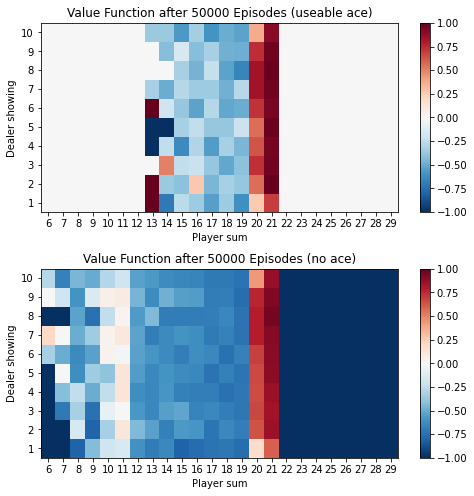

In [10]:
blackjack.plot_value_function(policy_value, title=f"Value Function after {n_episodes} Episodes")

## (3) Monte Carlo Control 
Implement the On-policy every-visit MC control for ε-soft policies algorithm.

In [11]:
def mc_control_epsilon_greedy(
    rng: np.random._generator.Generator, 
    env: gym.Env, 
    initial_policy: BlackJackPolicy, 
    n_episodes: int = 100, 
    gamma: float = 1.0, 
    epsilon: float = 0.1, 
    n_print_every: int = 10 ** 4
) -> Tuple[BlackJackPolicy, Dict[BlackJackState, np.ndarray]]:
    """
    On-policy every-visit MC control for ε-soft policies algorithm
    Computes an optimal epsilon-greedy policy.
    
    Args:
        rng: Random number generator
        env: the openai gym environment
        initial_policy: the inital policy as a dict with the state as the key,
                        and the values being numpy arrays that store the
                        action selection probabilities
        n_episodes: number of episodes to sample
        gamma: the discount factor
        epsilon: chance to sample a random action
        n_print_every : Print a message after this many episodes
    
    Returns:
        a tuple (policy, Q)
        opt_policy is a dict in the same format as the initial_policy
        Q is a dict with the state as the key,
        and an np.array as value, which contains the state-action values
"""
    
    # see the note on datastructures in 'mc_policy_evaluation(...)'!
    G_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    G_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # make a copy of the inital policy (it's bad style to change input parameters)
    policy = {k: v.copy() for k, v in initial_policy.items()}
    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        #generate an episode
        episode = generate_episode(rng, env,policy)
        
        #compute return G, update G_sum, G_count, and Q
        states,actions,rewards = zip(*episode)
        discount_factors = np.array([gamma**i for i in range(len(states)+1)])
        for ind,state in enumerate(states):
            G_t = sum(rewards[ind:]*discount_factors[:-(1+ind)])

            G_sum[state][actions[ind]] = G_sum[state][actions[ind]] + G_t
            G_count[state][actions[ind]] = G_count[state][actions[ind]] + 1
        
            Q[state][actions[ind]] = G_sum[state][actions[ind]]/G_count[state][actions[ind]]


        #derive an epsilon-soft policy from Q
        list_of_actions = np.arange(env.action_space.n)
        for state in states:
            greedy_action =  np.argmax(Q[state])
            non_greedy_action =  list_of_actions[list_of_actions != greedy_action]
            if state not in policy.keys():
                continue
            policy[state][greedy_action] = 1 - epsilon + epsilon/env.action_space.n
            policy[state][non_greedy_action] =  epsilon/env.action_space.n


    return policy, Q

### Run MC Control for Black Jack
Finally, let's compute a better policy for the Black Jack game.

In [12]:
# here, we start from the example policy
# policy = create_example_policy()
n_episodes = 10 ** 4
n_print_every = 10 ** 3

initial_policy = create_random_policy()

# and now run our MC control algorithm
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng,
    blackjack_env,
    initial_policy,
    n_episodes=n_episodes,
    epsilon=0.1,
    n_print_every=n_print_every
)

assert any([np.all(initial_policy[st] != val) for st, val in opt_policy.items()]), "Your policy was not changed"
for state, val in opt_Q.items():
    assert testing.is_type(state, tuple)
    assert testing.is_type(state[0], [int, np.int64])
    assert testing.is_type(state[1], [int, np.int64])
    assert testing.is_type(state[2], bool)
    assert testing.is_type(val, np.ndarray)

# determine how good our policy is, in terms of v(s)
opt_V = mc_policy_evaluation(
    rng,
    blackjack_env,
    opt_policy,
    n_episodes=n_episodes,
    n_print_every=n_print_every
)

Episode 1000/10000.
Episode 2000/10000.
Episode 3000/10000.
Episode 4000/10000.
Episode 5000/10000.
Episode 6000/10000.
Episode 7000/10000.
Episode 8000/10000.
Episode 9000/10000.
Episode 10000/10000.
Episode 1000/10000.
Episode 2000/10000.
Episode 3000/10000.
Episode 4000/10000.
Episode 5000/10000.
Episode 6000/10000.
Episode 7000/10000.
Episode 8000/10000.
Episode 9000/10000.
Episode 10000/10000.


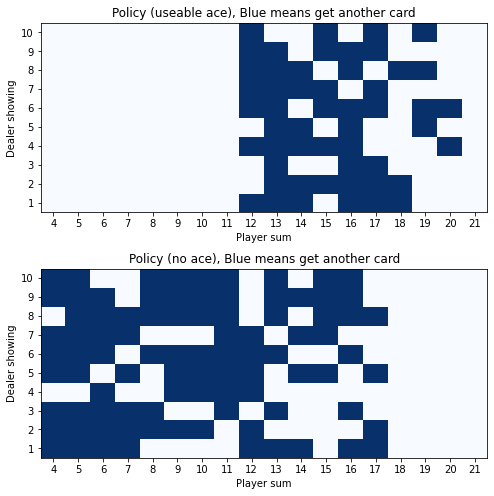

<Figure size 432x288 with 0 Axes>

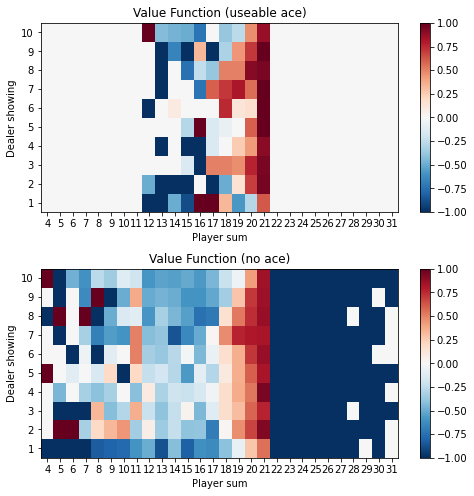

In [13]:
# plot the policy
blackjack.plot_policy(opt_policy)

# and its associated value function
blackjack.plot_value_function(opt_V)

---
# Fishlake Revisited with Monte Carlo methods
We will now go back to the Fishlake and run the MC algorithms on this problem. You will need to answer a textual question, after you tried MC on the Fishlake environment.

In [14]:
def d2a_policy(env, policy):
    policy_array = np.zeros((env.observation_space.n, env.action_space.n))
    for state, ap in policy.items():
        policy_array[state, :] = ap
    return policy_array

def d2a_V(env, V):
    V_array = np.zeros(env.observation_space.n)
    for state, value in V.items():
        V_array[state] = value
    return V_array

def fishlake_random_policy(env):
    policy = defaultdict()
    for state in range(env.observation_space.n):
        policy[state] = np.ones(env.action_space.n) / env.action_space.n
    return policy    

## Run MC Evaluation on Fishlake

In [15]:
# we start with the smaller lake
small_lake_env = gym.make('FishlakeStreamy-v0')
small_lake_env.seed(1234)

# let's create a random policy
random_policy = fishlake_random_policy(small_lake_env)

# and now let's see how good our policy is
rng = np.random.default_rng(4321)
V_dict = mc_policy_evaluation(rng, small_lake_env, random_policy, 200)

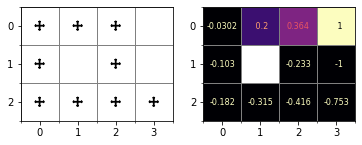

In [16]:
# let's plot this
random_policy_array = d2a_policy(small_lake_env, random_policy)
V_array = d2a_V(small_lake_env, V_dict)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, random_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, V_array)
plt.show()

## Run MC Control on Fishlake

In [17]:
# we start with the smaller lake
small_lake_env = gym.make('FishlakeStreamy-v0')
small_lake_env.seed(1234)

# let's create a random policy
initial_policy = fishlake_random_policy(small_lake_env)
rng = np.random.default_rng(4321)
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng,
    small_lake_env,
    initial_policy,
    n_episodes=10 ** 4,
    epsilon=0.1
)

# and now let's see how good our policy is
opt_V = mc_policy_evaluation(rng, small_lake_env, opt_policy, n_episodes=10 ** 4)

Episode 10000/10000.
Episode 10000/10000.


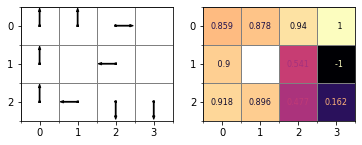

In [18]:
# let's plot this
opt_policy_array = d2a_policy(small_lake_env, opt_policy)
opt_V_array = d2a_V(small_lake_env, opt_V)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, opt_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, opt_V_array)
plt.show()